## The glorious bounty of Strain 24

### Required R packages

In [1]:
require(ggplot2)
require(dplyr)
require(tidyr)
require(viridis)  # for a nice colormap
require(stringr)  # for easier string functions in R
require(gridExtra)  # for assembling and aligning multiple plots
require(cowplot)  # for assembling and aligning multiple plots

# homebrewed R code
source('../code/experiment_01_helper_functions.r')

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: viridis
Loading required package: stringr
Loading required package: gridExtra
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: xcms
Loading required package: mzR
Loading required package: Rcpp
Warning message:
In fun(libname, pkgname): mzR has been built against a different Rcpp version (0.12.1)
than is installed on your system (0.12.2). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://

## Loading fully-processed xcms data for all 27 samples

In [2]:
# load fully-processed xcms data of all 27 samples
load('../saved_data/experimental_design_and_sample_table.rdat')
load('../saved_data/xset_samps_filled.rdat')

# load TIC data
load('../saved_data/extracted_TIC_data.rdat')

## Comparing strain 24 to strain 7

Loading required package: multtest


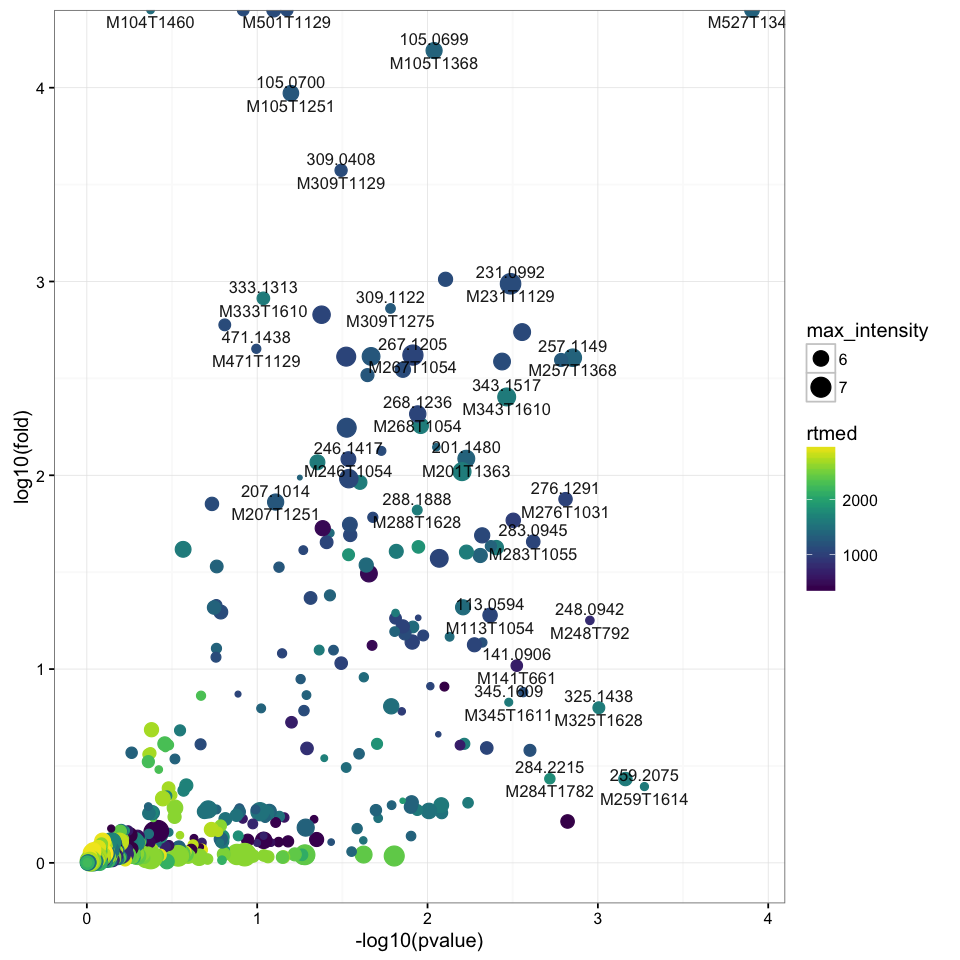

In [3]:
myreport <- do_diffreport_and_plot(xset_samps_filled, class1='7:sup', class2='24:sup', 
                                   max_intensity_cutoff = 5,
                                   label_top_n=35)


show(myreport[['plot']]) 

There are many interesting features in the above plot.  We can further filter them through several criteria:

* Keep only those which are 20-fold upregulated or more in Strain 24 relative to the controll
    * N.B. the xcms fold-change is calculated from "filled" data, where each feature found during global alignment is used to define an RT / MZ range, and data from files/samples where no peak was found are manually filled over the identified RT / MZ ranges.  The presence of noise in mass spectra means that during this filling process, even the control sample will show as having some intensity for identified features.
    
    
* Keep only those found in 6 samples or fewer.
    * The `npeaks` field of xcms `diffreport()` or `peakTable()` results shows the number of times a peak was identified across all samples, *before filling*.  Since: (i) Strain 24 is Cluster Cs100, a cluster also present in Strain 18, and (ii) each culture was analyzed in triplicate, restricting the `npeaks` to 6 allows for features that appear in both Strain 18 and Strain 24 to be retained.  
    
* Keep only those with a p-value below $p=0.01$.

* At each retention time, keep only the feature that has the maximum intensity at that retention time.

The code below does this filtering.

In [11]:
# simplify the name of the diffReport() to save typing
mydf <- myreport[['reporttab']]

# filter out features as described above and sort by retention time
mydf <- mydf[mydf$fold > 20 & mydf$npeaks <= 27 & mydf$pvalue < 0.1,]
mydf <- mydf[order(mydf$rtmed), ]

# group features by approxiamte retention time
mydf$approx_rt <- sprintf('%.1f', as.numeric(str_extract(mydf$name, '(?<=T)[0-9]*'))/60)

# dplyr is awesome
summary_table <- mydf %>% 
    group_by(approx_rt) %>% 
    filter(max_intensity==max(max_intensity) | mzmed==max(mzmed)) %>% 
    select_(.dots=c('name', 'fold', 'mzmed', 'max_intensity', 'rtmin', 'rtmax'))

# show the results
summary_table

,approx_rt,name,fold,mzmed,max_intensity,rtmin,rtmax
1,16.4,M241T982,58.56677,241.1409,5.800008,981.7127,984.2178
2,17.2,M276T1031,75.28098,276.1291,5.642816,1030.013,1032.127
3,17.6,M267T1054,417.0956,267.1205,7.047931,1053,1055.048
4,17.6,M283T1055,45.41888,283.0945,5.662327,1054.628,1055.131
5,18.1,M197T1084,96.06994,197.115,6.60762,1082.985,1084.07
6,18.2,M273T1093,548.2613,273.1098,6.260167,1091.577,1094.065
7,18.8,M501T1129,Inf,501.1793,5.486644,1128.522,1129.041
8,18.8,M231T1129,973.1753,231.0992,7.128398,1128.962,1130.027
9,20.8,M230T1250,328.7925,230.0868,5.586613,1249.556,1250.893
10,20.9,M229T1251,410.4854,229.0835,6.457751,1249.556,1250.903


Uniquely for this strain (and strain 18 which expresses the same cluster), interesting peaks were clearly present in the TIC.  We can align the feature scatter (similar to above) and plot with the TIC:

In [5]:
# Scatter plot with m/z on the y-axis and retention time on the x-axis
p <- ggplot(data=myreport[['reporttab']], aes(x=rtmed/60, y=mzmed, size=max_intensity, color=-log10(pvalue),
                                         label=paste(sprintf('%.4f', mzmed), name, sep='\n'))) + 
    geom_point() +
    geom_text(size=3, color='black', check_overlap = T) +
    scale_color_gradientn(colors=viridis(20)) +
    theme_bw() +
    scale_size_continuous(range=c(0, 8), limits=c(5.5, 8), breaks=c(5.5, 6, 6.5, 7)) +
    xlim(c(950, 1650)/60) + 
    xlab('') + 
    ylab('m/z, Da')


In [6]:
# annotating the TIC data with strain information
samp_TICs$sample_id <- as.integer(str_extract(samp_TICs$file, regex('[0-9]{2}(?=[.]mzML)')))
blank_TICs$blank_id <- as.factor(str_extract(blank_TICs$file, regex('[0-9]{1}(?=[_][.]mzML)')))

# for samples, annotate with sample information
samp_TICs <- merge(samp_TICs, my_dat, by='sample_id')

In [7]:
# The TIC plot
vs.24_7 <- samp_TICs$fraction == 'sup' & samp_TICs$strain_id %in% c(7, 24)
q <- ggplot(data=samp_TICs[vs.24_7, ], aes(x=rt/60, y=intensity, color=strain_id, group=sample_id) ) + 
    geom_line(size=0.6) +
    theme_bw() + 
    ylim(0, 6e6) + 
    scale_color_brewer(palette = "Dark2") +
    xlab('Retention time, min') + 
    ylab('TIC') +
    scale_x_continuous(breaks=seq(15, 27, 0.5), limits=c(950, 1650)/60)

Warning message:
: Removed 24 rows containing missing values (geom_point).Warning message:
: Removed 4 rows containing missing values (geom_text).Warning message:
: Removed 31186 rows containing missing values (geom_path).

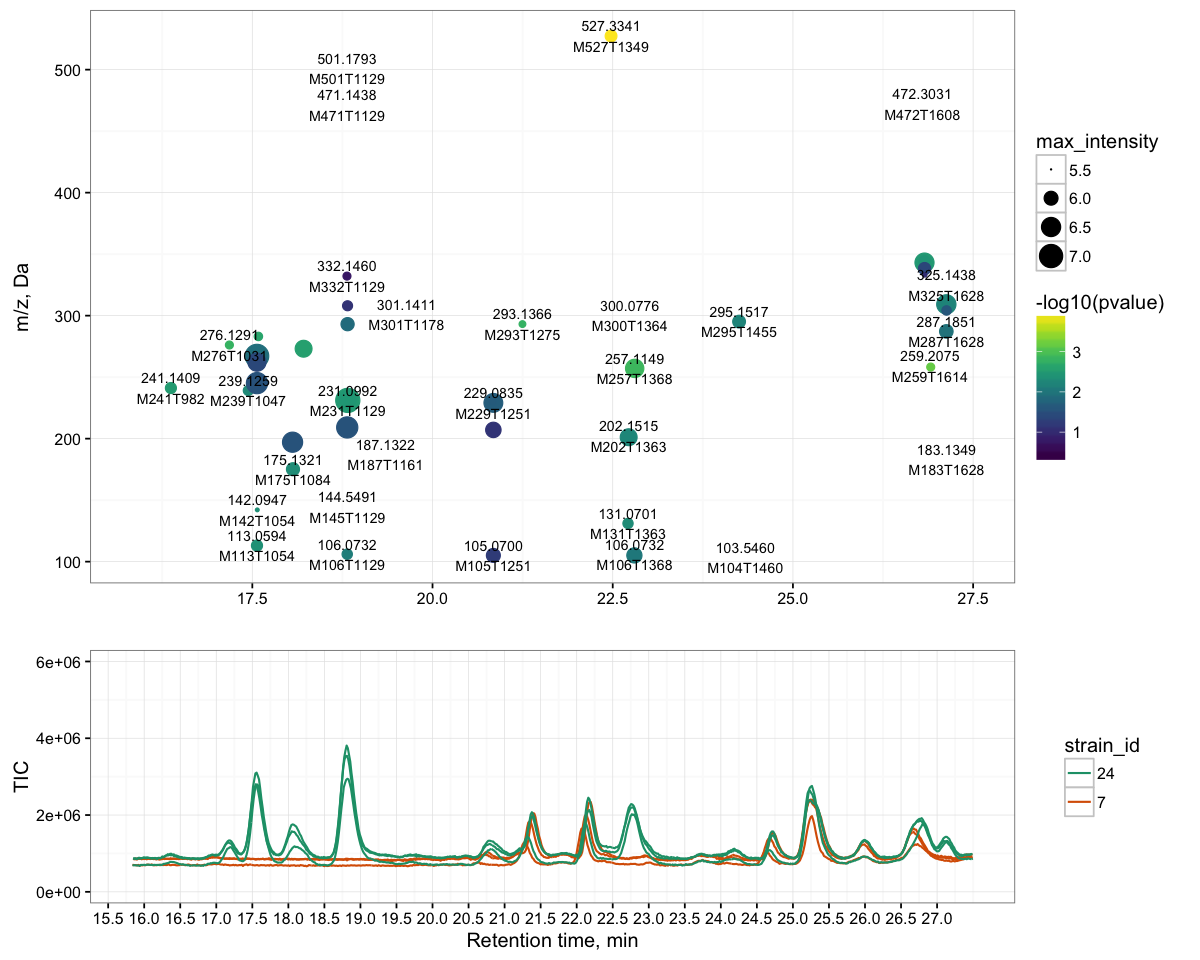

In [8]:
# Combining and aligning the two plots
options(repr.plot.width=10, repr.plot.height=8)
plot_grid(p, q, ncol=1, align="v", rel_heights = c(2, 1))

## Plotting EICs for selected features

04 05 06 19 20 21 


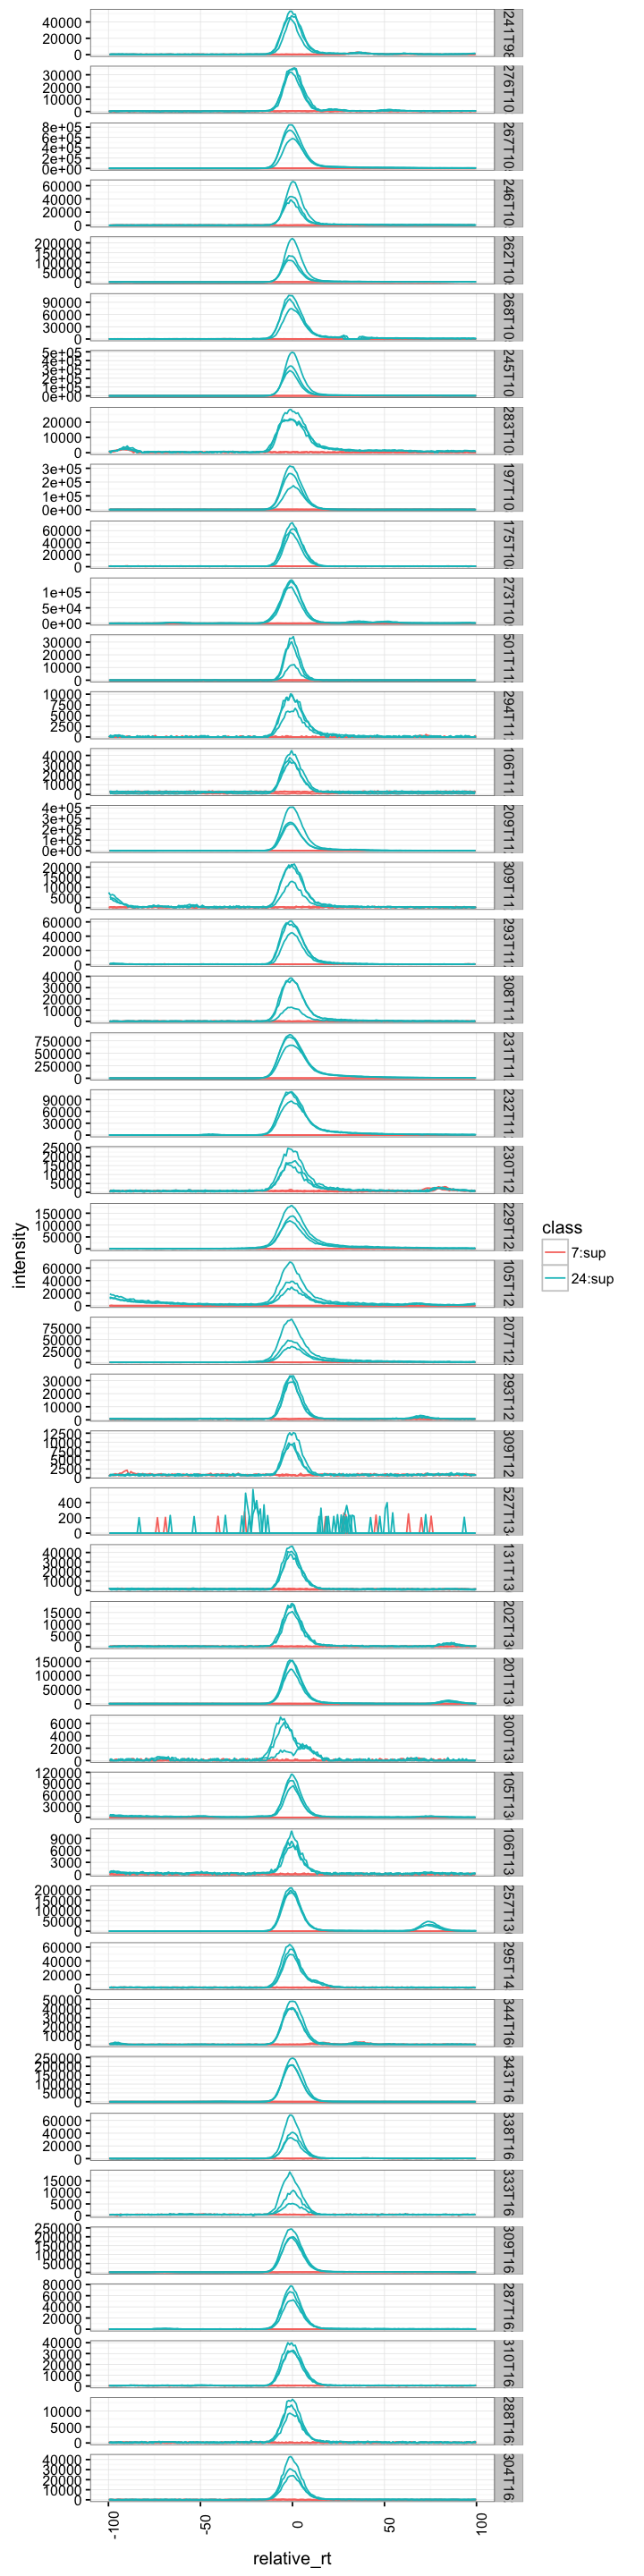

In [9]:
# plot EICs for filtered features

EICdat <- getEICdf(xset_samps_filled,
                     groupidx=as.character(summary_table$name),
                     sampleidx=sampnames(xset_samps_filled)[sampclass(xset_samps_filled) %in% c('7:sup', '24:sup')]
                     )

EICdat[['plot']] 

In [15]:
# if you prefer a different plotting format
head(EICdat[['eic_data']])
options(repr.plot.width=10, repr.plot.height=12)

ggplot(data=EICdat[['eic_data']], aes(x=rt/60, y=intensity, color=class)) + 
    geom_line() + 
    facet_grid(groupname~., scales='free_y', labeller=mzmed) +
    xlab('Retention time, min') +
    theme_bw() + 
    theme(strip.text.y = element_text(angle=0))


,rt,intensity,sample,mzrange.1,mzrange.2,groupname,class,relative_rt
1,883.5308,231.7264,04,241.1356,241.1453,M241T982,7:sup,-99.25666
2,884.5283,283.722,04,241.1356,241.1453,M241T982,7:sup,-98.25918
3,885.5268,383.3649,04,241.1356,241.1453,M241T982,7:sup,-97.26072
4,886.5242,508.4194,04,241.1356,241.1453,M241T982,7:sup,-96.26325
5,887.5217,408.134,04,241.1356,241.1453,M241T982,7:sup,-95.26579
6,888.5192,0,04,241.1356,241.1453,M241T982,7:sup,-94.26833


ERROR: Error in match.fun(labeller): object 'mzmed' not found


## Formula finding

For finding potential formulae from "exact" $m/z$ values, I use Python, not R. See the notebook at `../formulae_from_mz.ipynb`.  The algorithm used there is not as good as Agilent's software, because it doesn't use any isotopic envelope information, but it (a) free, (b) available for use anywhere, (c) blazingly fast, and (d) independent of any data other than $m/z$.